In [1]:
%load_ext autoreload
%autoreload 2

### Use python 3.8.10 to run this notebook !

### Install following packages  

In [2]:
# !pip install tqdm==4.61.2
# !pip install numpy==1.20.3
# !pip install scikit-learn==0.24.2
# !pip install pandas==1.4.1
# !pip install umap-learn==0.4.6
# !pip install anndata==0.7.4
# !pip install ripser==0.6.1
# !pip install Cython==0.29.21
# !pip install numba==0.51.2
# !pip install seaborn
# !pip install tables==3.6.1
# !pip install legacy-api-wrap==1.2
# !pip install scikit-network==0.24.0

In [3]:
import matplotlib.pyplot as plt
from anndata import AnnData
import scanpy_modified as scanpy
from tqdm import tqdm
import numpy as np
from numpy import inf
from ripser import Rips
from scipy.spatial import distance
from numpy import linalg as LA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
import sklearn
import pandas as pd
from sklearn.manifold import TSNE
import umap
import glob, os
from sklearn.decomposition import PCA
import sys
import time
import random
import seaborn as sns
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from utils import features_dpt_entropy, features_homology_dpt_entropy, features_vector
from utils import features_ripley_dpt_v2, preprocessing, features_avg_connection_dpt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sknetwork.data import karate_club, painters, movie_actor
from sknetwork.clustering import Louvain, modularity, bimodularity
from sklearn.neighbors import kneighbors_graph
from matplotlib import pyplot as plt
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox

eps = sys.float_info.epsilon
pd.set_option("display.max_rows", None, "display.max_columns", None)

### Importing pre-calculated simulated dataset scores

In [4]:
META_SCORES = list(np.load('metascore_12000.npy'))

## Correlation among the scores

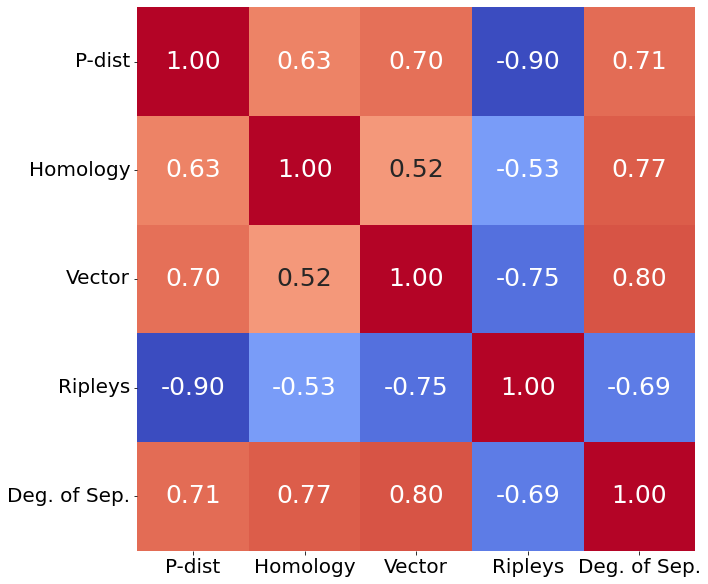

In [5]:
feature_names = ['P-dist','Homology','Vector','Ripleys','Deg. of Sep.']
df_sim_scores = pd.DataFrame(META_SCORES, columns=feature_names)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_sim_scores.corr(method='pearson'), annot=True, fmt='.2f', 
            cmap=plt.get_cmap('coolwarm'), cbar=False, ax=ax, annot_kws={"fontsize":25})
ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal", fontsize = 20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 20)
plt.show()

In [6]:
clstr = META_SCORES[:3000]
traj = META_SCORES[3000:6000]
clstr_r1 = META_SCORES[6000:7500]
traj_r1 = META_SCORES[7500:9000]
clstr_r2 = META_SCORES[9000:10500]
traj_r2 = META_SCORES[10500:12000]

npy_sim = np.array(META_SCORES)
print(npy_sim.shape)

(12000, 5)


## Violin plots of simulated datasets 

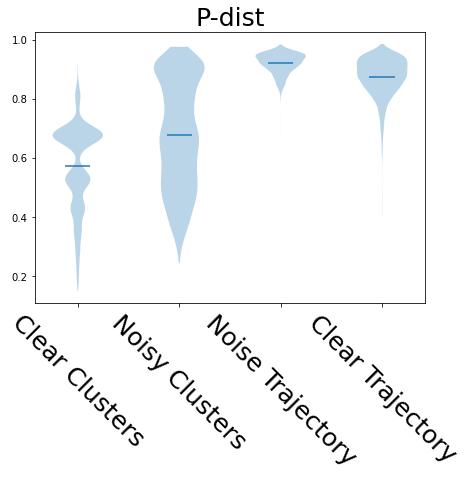

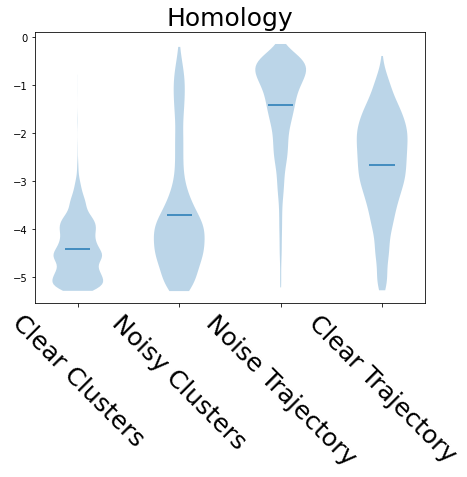

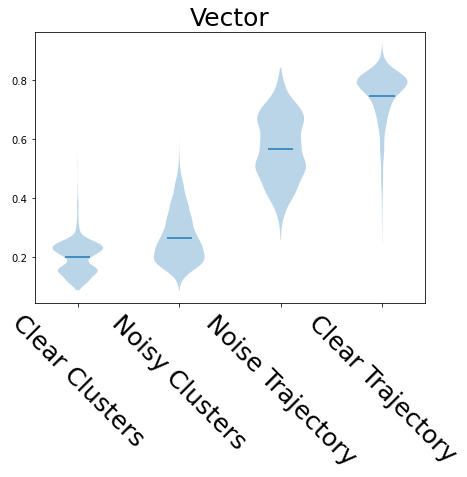

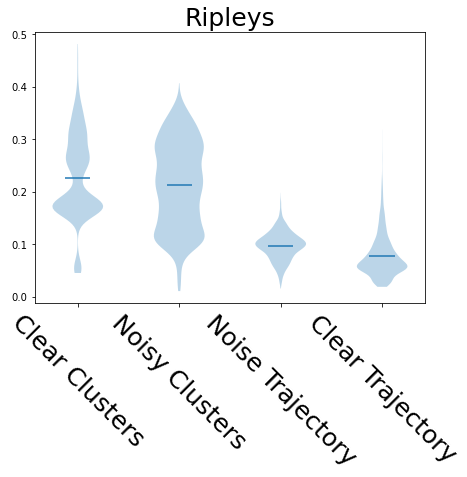

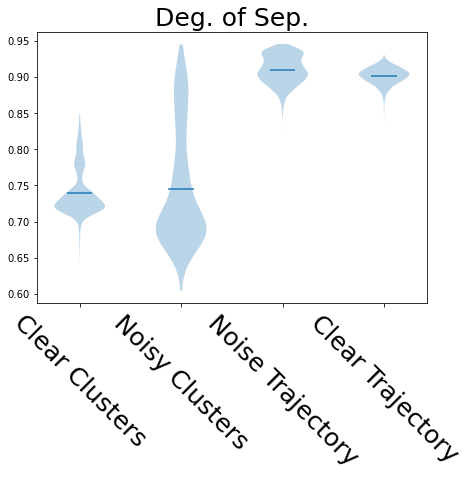

In [7]:
for i in range(len(feature_names)):
    feat = i
    plt.figure(figsize=(7,5))
    plt.violinplot([np.array(clstr)[:,feat],
                    np.array(clstr_r1 + clstr_r2)[:,feat],
                    np.array(traj_r1 + traj_r2)[:,feat],
                    np.array(traj)[:,feat]],
                  showmeans = True, showextrema=False)
    plt.title(feature_names[i], fontsize = 25)
    plt.xticks(fontsize=25, rotation=315)
    plt.xticks([1, 2, 3, 4], ['Clear Clusters','Noisy Clusters','Noise Trajectory','Clear Trajectory'])
    plt.show()

## UMAP projections of the simulated datasets 

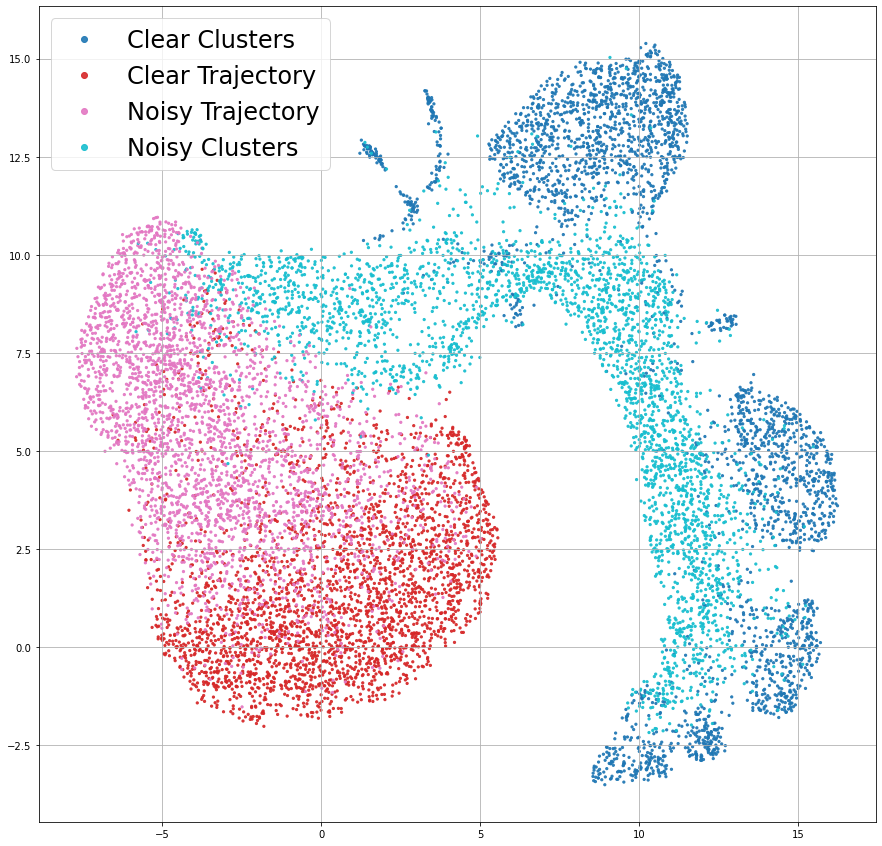

In [8]:
metric = 'euclidean'
seed = 1
n_neighbors = 50
min_dist = 0.6
figsize = 15

scaler = StandardScaler()
tmp_np = scaler.fit_transform(npy_sim)
tmp_reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=2,random_state=seed,min_dist=min_dist, metric=metric)
embedding = tmp_reducer.fit_transform(tmp_np)

classes = ['Clear Clusters','Clear Trajectory','Noisy Trajectory','Noisy Clusters']
c1 = [0 for i in range(3000)]
c2 = [1 for i in range(3000)]
c3 = [3 for i in range(1500)]
c4 = [2 for i in range(1500)]
c5 = [3 for i in range(1500)]
c6 = [2 for i in range(1500)]

c = c1+c2+c3+c4+c5+c6

plt.figure(figsize=(figsize,figsize))
scatter = plt.scatter(embedding[:,0],embedding[:,1], s=5, c=c, cmap = 'tab10', alpha = 0.9)
plt.legend(handles=scatter.legend_elements()[0], labels=classes,prop={'size': 24})
plt.grid()
plt.show()

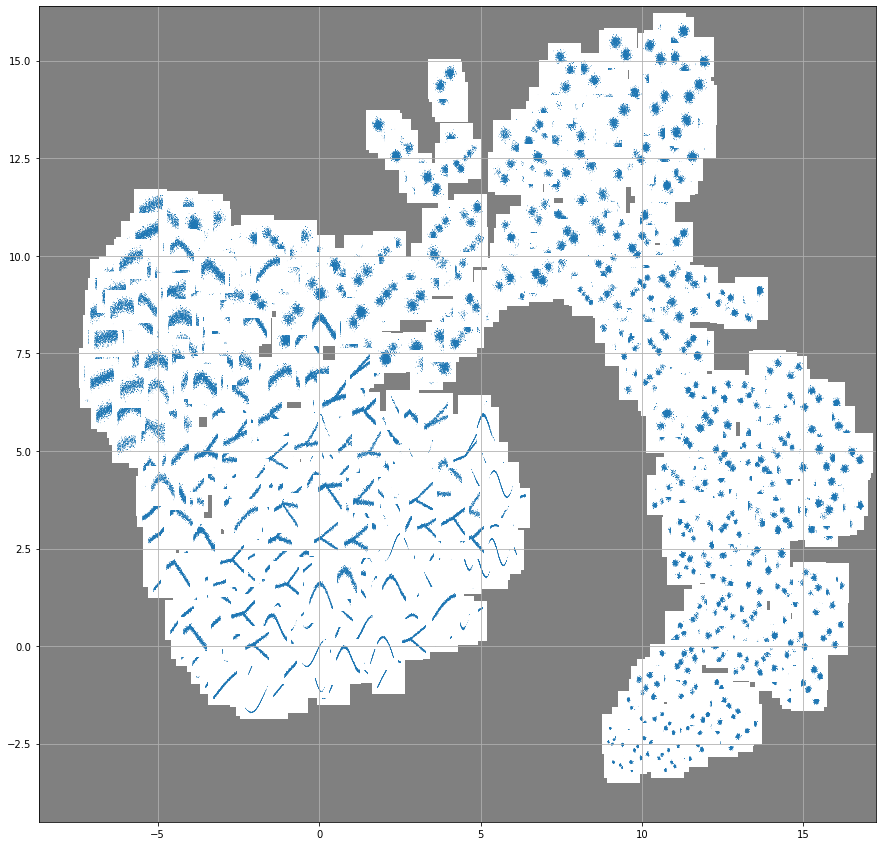

In [9]:
def plotImage(x, y, im):
    bb = Bbox.from_bounds(x,y,1,1)  
    bb2 = TransformedBbox(bb,ax.transData)
    bbox_image = BboxImage(bb2,
                        norm = None,
                        origin=None,
                        clip_on=False)

    bbox_image.set_data(im)
    ax.add_artist(bbox_image)
    
fig = plt.figure(figsize=(figsize,figsize))
ax = fig.add_subplot(111)
ax.grid()
ax.set_facecolor('gray')
for i in range(len(npy_sim)):
    if random.uniform(0, 1) < 0.1:
        plotImage(embedding[i][0], embedding[i][1], plt.imread('scatterplots_simulated_data/{}.png'.format(i+1)))
    else:
        continue

# Set the x and y limits
border = 1
ax.set_ylim(np.min(embedding, axis =0)[1]-border,np.max(embedding, axis =0)[1]+border)
ax.set_xlim(np.min(embedding, axis =0)[0]-border,np.max(embedding, axis =0)[0]+border)
plt.show()

## Score distributions in the projection 

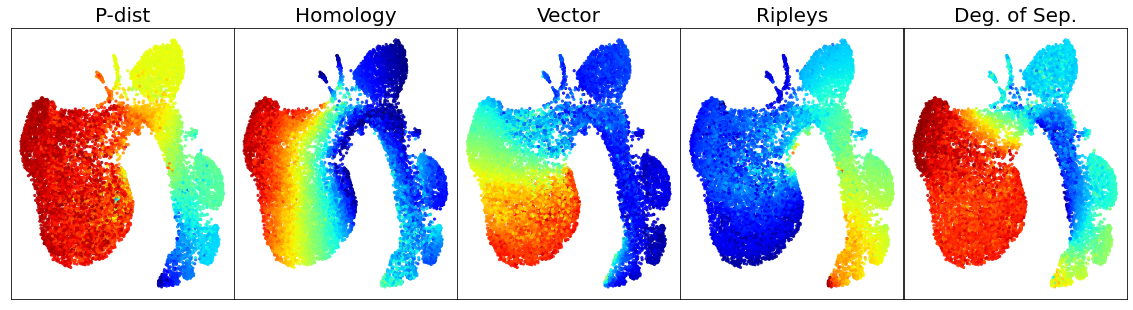

In [10]:
fig, axs = plt.subplots(1,5, figsize=(20, 5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i in range(5):
    axs[i].scatter(embedding[:,0],embedding[:,1], s=5,c= npy_sim[:len(embedding),i], cmap = 'jet', alpha = 0.8)
    axs[i].set_title(feature_names[i], fontsize=20)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

### Loading real data

In [11]:
def load_real_data(pca_dim = 20, seed = 0):
    np.random.seed(seed)
    files = []
    for file in glob.glob("scData/*.csv"):
        files.append(file)
    df_real = []
    for file in tqdm(files,position=0, leave=True):
        df = pd.read_csv(file, index_col=0)
        npy_array = np.array(df)
        if len(npy_array) > 10000:
            npy_array = npy_array[np.random.randint(len(npy_array), size=10000),:]
        pca = PCA(n_components=pca_dim)
        embedding = pca.fit_transform(npy_array)
        df_real.append(embedding)
    return df_real

In [12]:
files = []
for file in glob.glob("scData/*.csv"):
    files.append(file)
df_real = load_real_data()

100%|█████████████████████████████████████████████| 8/8 [00:09<00:00,  1.24s/it]


## Calculation of the metrics  

In [22]:
META_SCORES_REAL = []
for df in tqdm(df_real, position=0, leave=True):
    df = preprocessing(df)
    sc1 = features_dpt_entropy(df, num_bins = 10)
    sc2 = features_homology_dpt_entropy(df,num_bins = 3)
    sc3 = features_vector(df)
    sc4 = features_ripley_dpt_v2(df)
    sc5 = features_avg_connection_dpt(df)
    scores = [sc1,sc2,sc3,sc4,sc5] 
    META_SCORES_REAL.append(scores)

npy_real = np.stack(META_SCORES_REAL)

100%|█████████████████████████████████████████████| 8/8 [02:45<00:00, 20.71s/it]


In [14]:
npy_real.shape

(8, 5)

In [15]:
files = []
for file in glob.glob("scData/*.csv"):
    files.append(file)

simple_names = []
for name in files:
    simple_names.append(name.split('scData/')[1].split('.rds')[0])

In [16]:
simple_names

['epiblast-monkey',
 'planaria-combination',
 'bone-marrow-mesenchyme-erythrocyte',
 'NKT-differentiation',
 'dentate-gyrus-neurogenesis',
 'epidermis-hair-IFE',
 'mouse-cell-atlas-combination',
 'planaria-parenchyme-differentiation']

## Projection of real scData to the UMAP

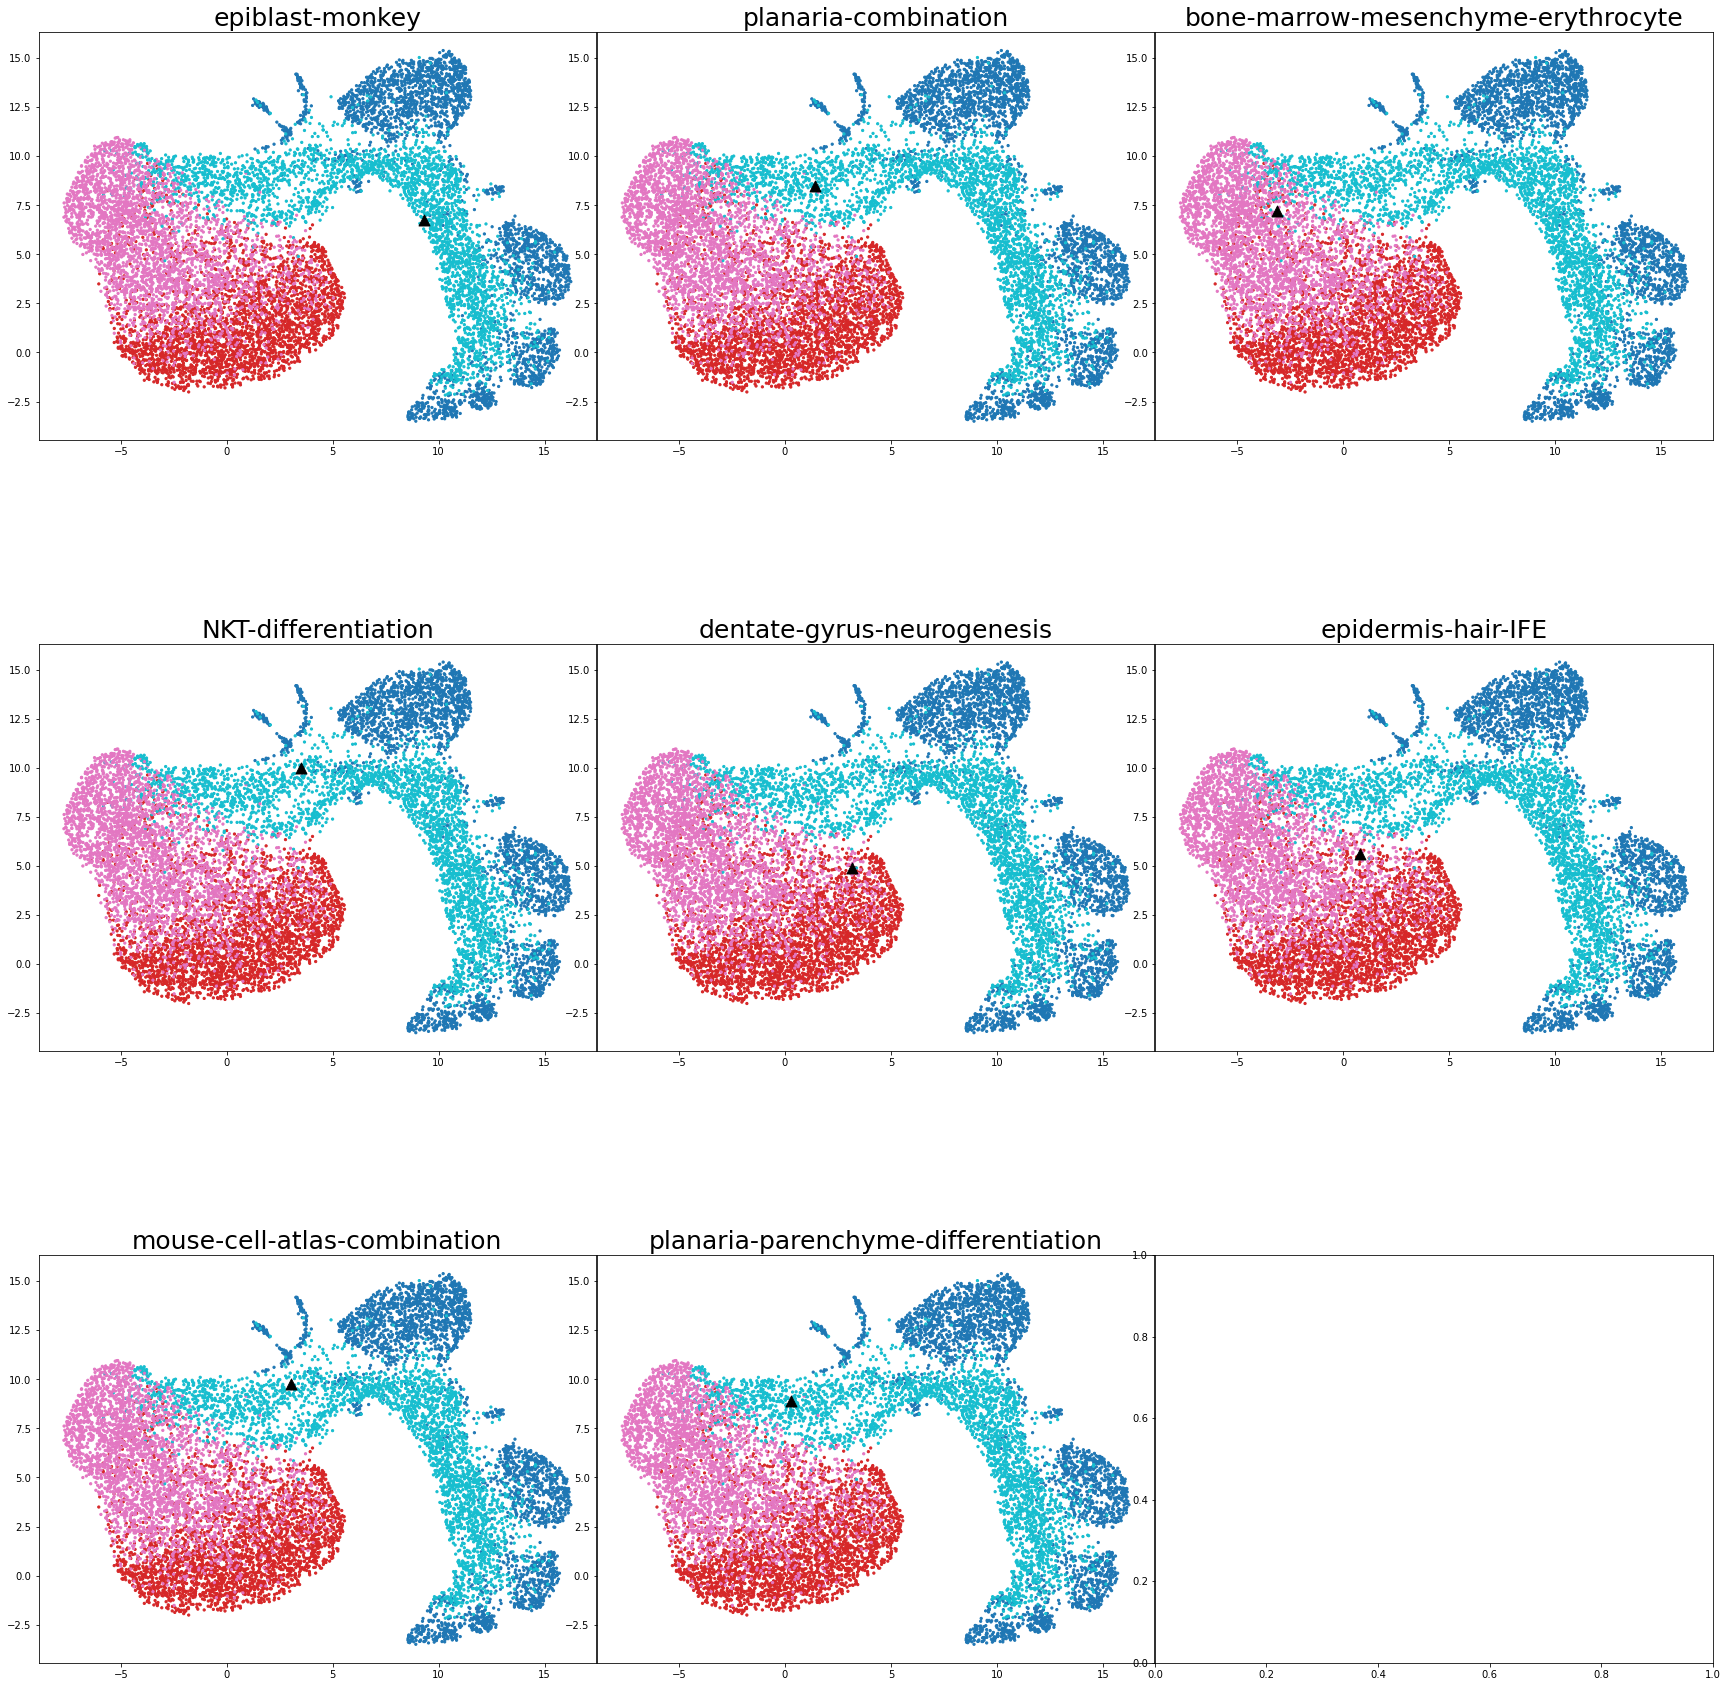

In [17]:
fig, axs = plt.subplots(3,3, figsize=(30, 30), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i in range(len(npy_real)):
    tmp_real = scaler.transform(npy_real[i,:].reshape(1, -1))
    d2_real_embedding = tmp_reducer.transform(tmp_real.reshape(1, -1))
    axs[i].scatter(embedding[:,0],embedding[:,1], s=5, c=c, cmap = 'tab10', alpha = 1)
    axs[i].scatter(d2_real_embedding[:,0],d2_real_embedding[:,1],marker='^',c='k',s=120, alpha =1)    
    axs[i].set_title(simple_names[i],fontsize=25)
    

epiblast-monkey


/Users/lim/opt/anaconda3/envs/SCdiff/lib/python3.8/site-packages/matplotlib/collections.py:1099: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


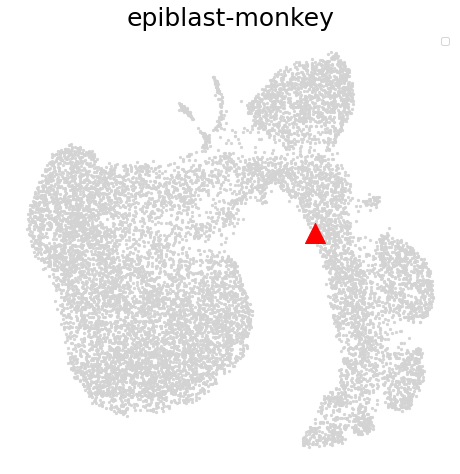

planaria-combination


/Users/lim/opt/anaconda3/envs/SCdiff/lib/python3.8/site-packages/matplotlib/collections.py:1099: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


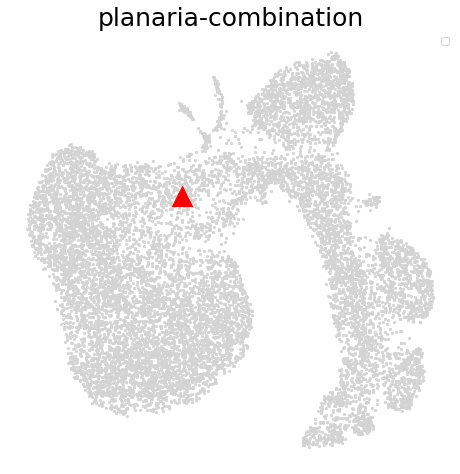

bone-marrow-mesenchyme-erythrocyte


/Users/lim/opt/anaconda3/envs/SCdiff/lib/python3.8/site-packages/matplotlib/collections.py:1099: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


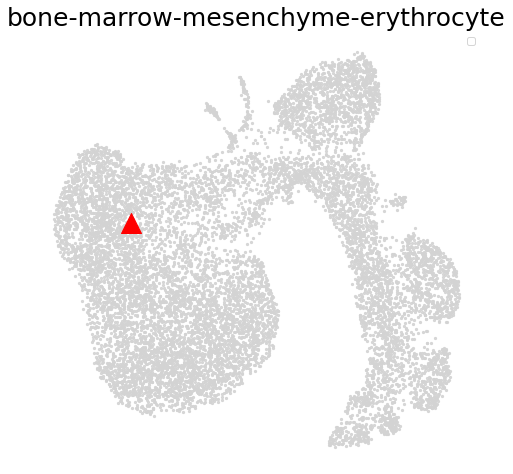

NKT-differentiation


/Users/lim/opt/anaconda3/envs/SCdiff/lib/python3.8/site-packages/matplotlib/collections.py:1099: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


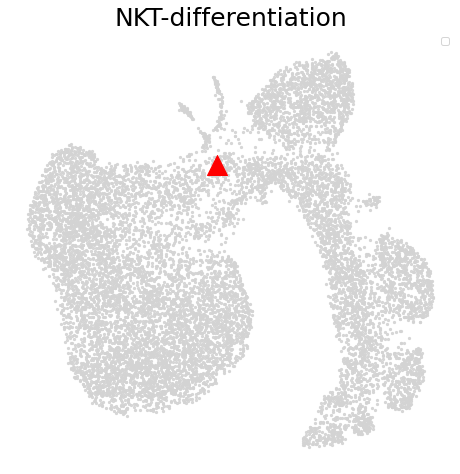

dentate-gyrus-neurogenesis


/Users/lim/opt/anaconda3/envs/SCdiff/lib/python3.8/site-packages/matplotlib/collections.py:1099: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


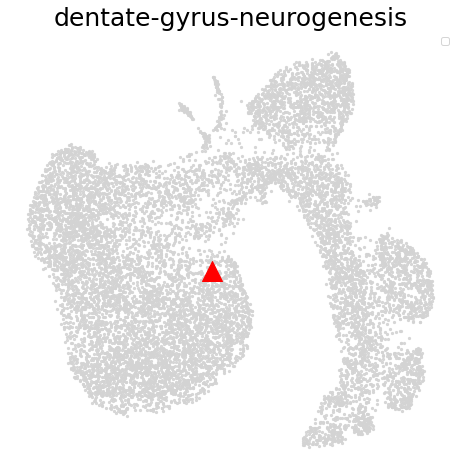

epidermis-hair-IFE


/Users/lim/opt/anaconda3/envs/SCdiff/lib/python3.8/site-packages/matplotlib/collections.py:1099: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


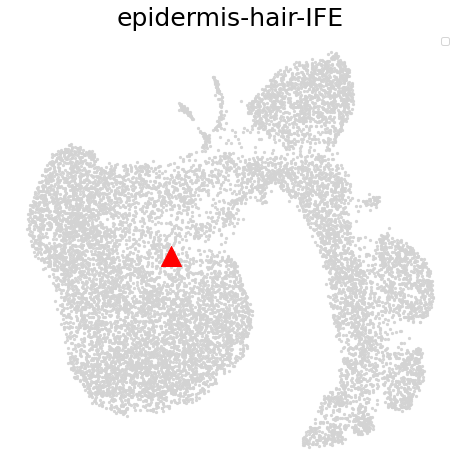

mouse-cell-atlas-combination


/Users/lim/opt/anaconda3/envs/SCdiff/lib/python3.8/site-packages/matplotlib/collections.py:1099: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


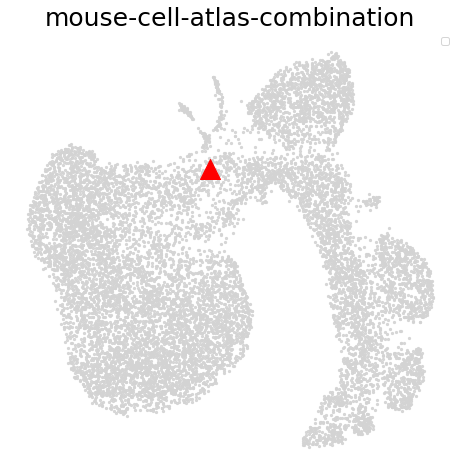

planaria-parenchyme-differentiation


/Users/lim/opt/anaconda3/envs/SCdiff/lib/python3.8/site-packages/matplotlib/collections.py:1099: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


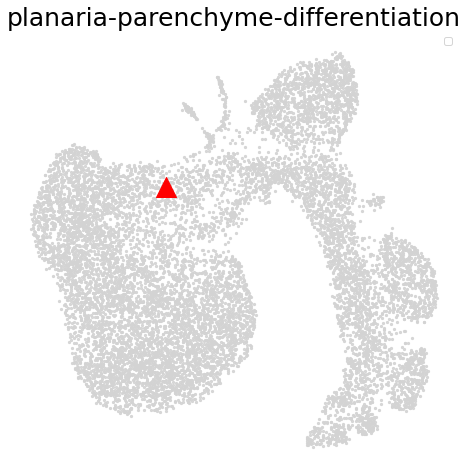

In [18]:
for i in range(len(npy_real)):
    print(simple_names[i])
    tmp_real = scaler.transform(npy_real[i,:].reshape(1, -1))
    d2_real_embedding = tmp_reducer.transform(tmp_real.reshape(1, -1))
    plt.figure(figsize=(8,8))
    scatter = plt.scatter(embedding[:,0],embedding[:,1], s=5, c="lightgrey", alpha = 0.9)
    plt.scatter(d2_real_embedding[:,0],d2_real_embedding[:,1],marker='^',c='r',s=400, alpha =1)   
    plt.legend(handles=scatter.legend_elements()[0], labels=classes)
    plt.title(simple_names[i],fontsize=25)
    plt.axis('off')
    plt.grid()
    plt.show()

## sc Visualizations 

scData/epiblast-monkey.rds.csv


/Users/lim/opt/anaconda3/envs/SCdiff/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  if is_string_dtype(df[key]) and not is_categorical(df[key])


<Figure size 576x576 with 0 Axes>

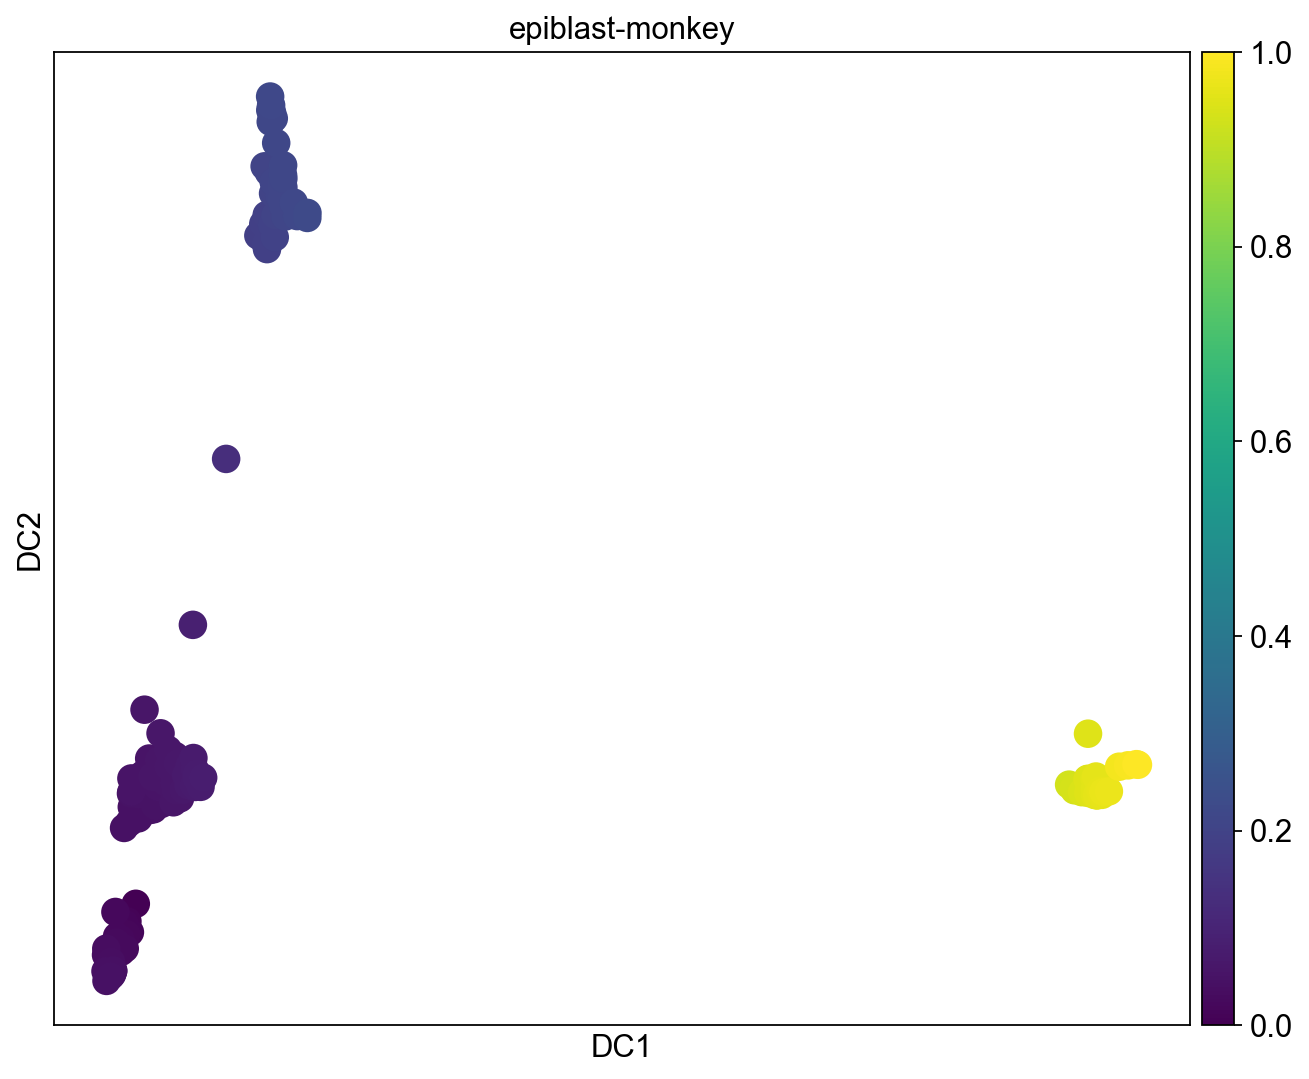

scData/planaria-combination.rds.csv


/Users/lim/opt/anaconda3/envs/SCdiff/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  if is_string_dtype(df[key]) and not is_categorical(df[key])


<Figure size 640x640 with 0 Axes>

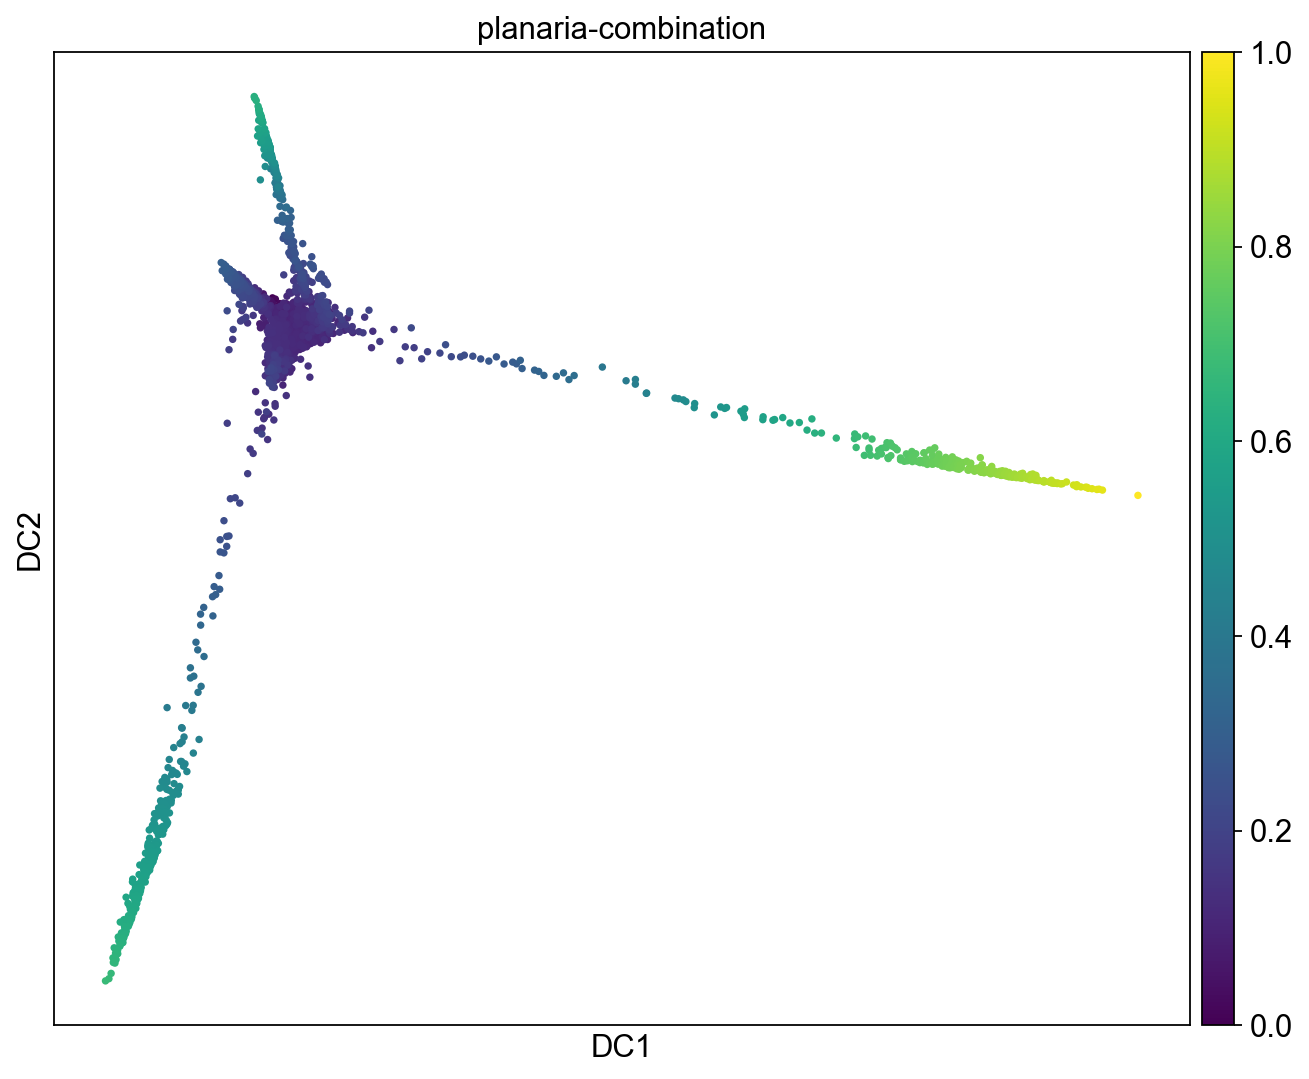

scData/bone-marrow-mesenchyme-erythrocyte.rds.csv


/Users/lim/opt/anaconda3/envs/SCdiff/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  if is_string_dtype(df[key]) and not is_categorical(df[key])


<Figure size 640x640 with 0 Axes>

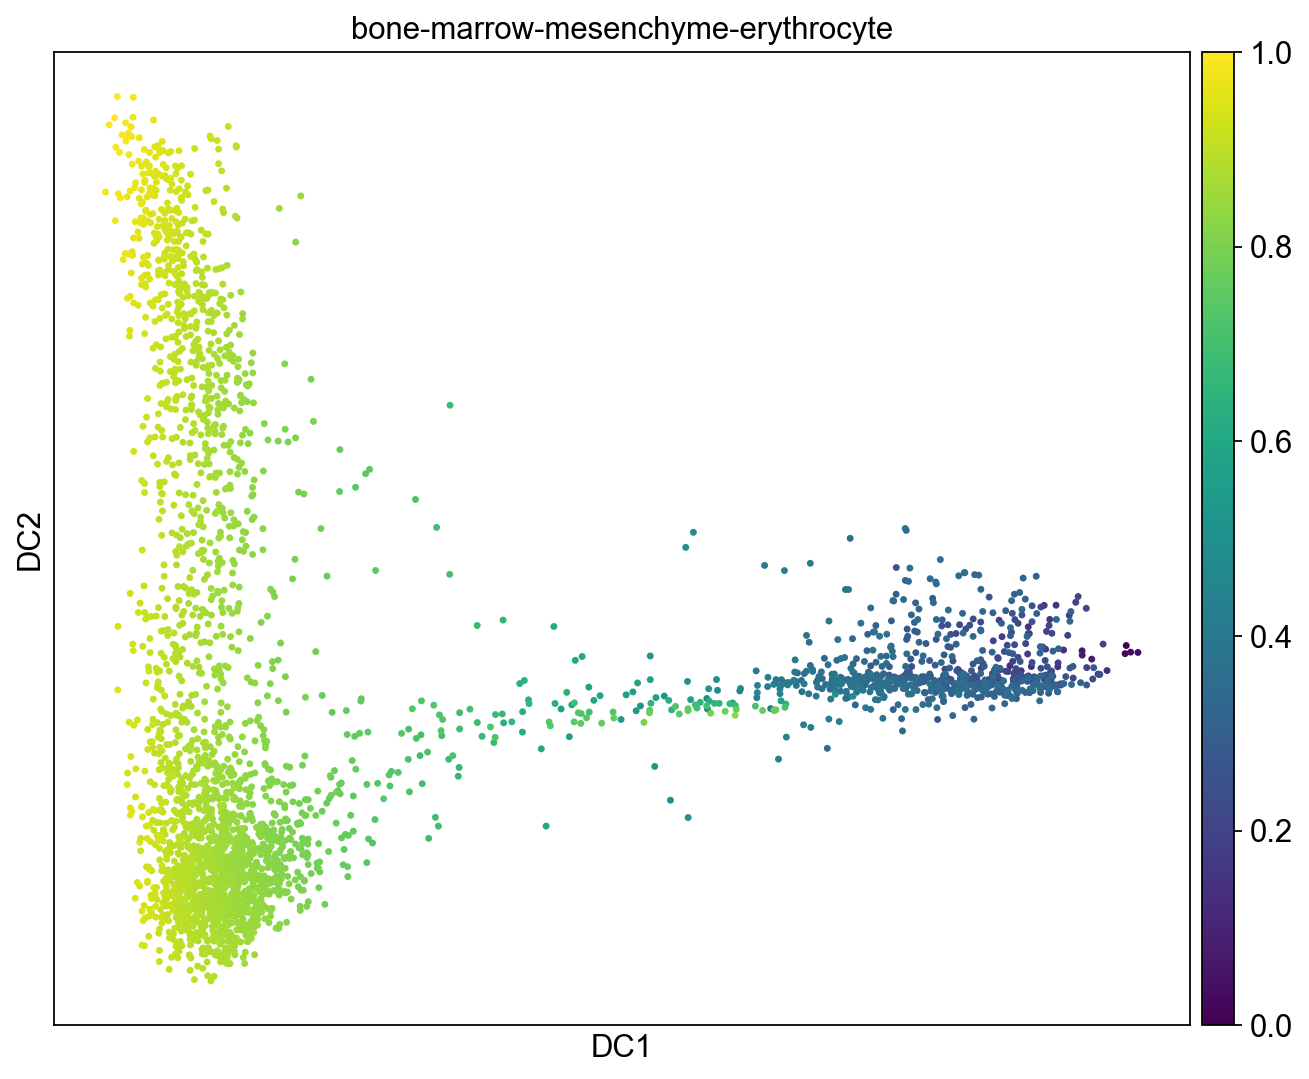

scData/NKT-differentiation.rds.csv


/Users/lim/opt/anaconda3/envs/SCdiff/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  if is_string_dtype(df[key]) and not is_categorical(df[key])


<Figure size 640x640 with 0 Axes>

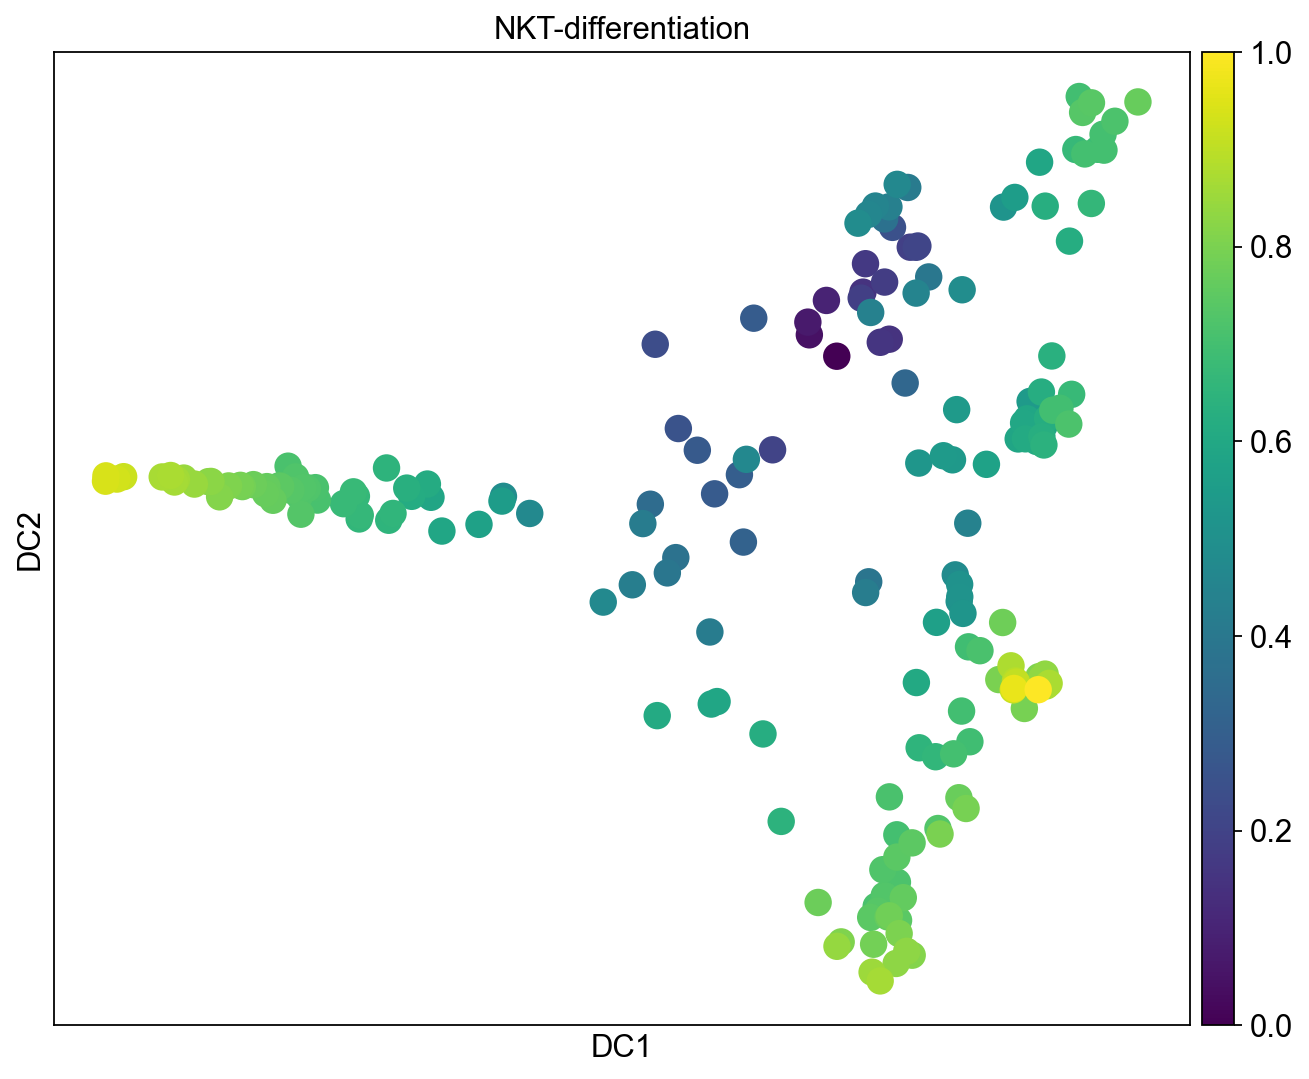

scData/dentate-gyrus-neurogenesis.rds.csv


/Users/lim/opt/anaconda3/envs/SCdiff/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  if is_string_dtype(df[key]) and not is_categorical(df[key])


<Figure size 640x640 with 0 Axes>

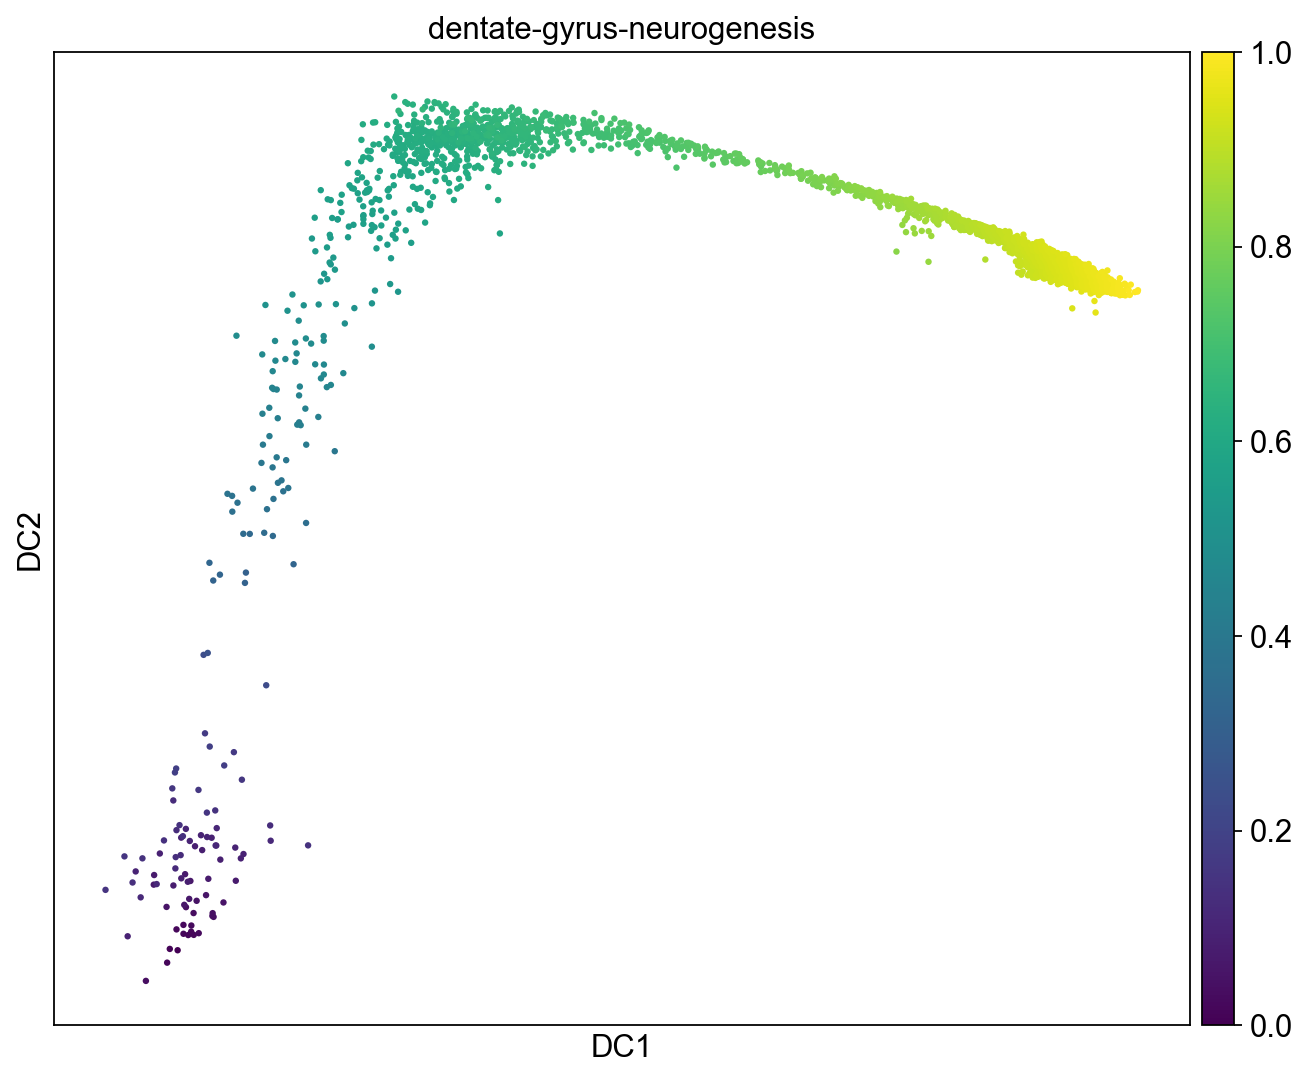

scData/epidermis-hair-IFE.rds.csv


/Users/lim/opt/anaconda3/envs/SCdiff/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  if is_string_dtype(df[key]) and not is_categorical(df[key])


<Figure size 640x640 with 0 Axes>

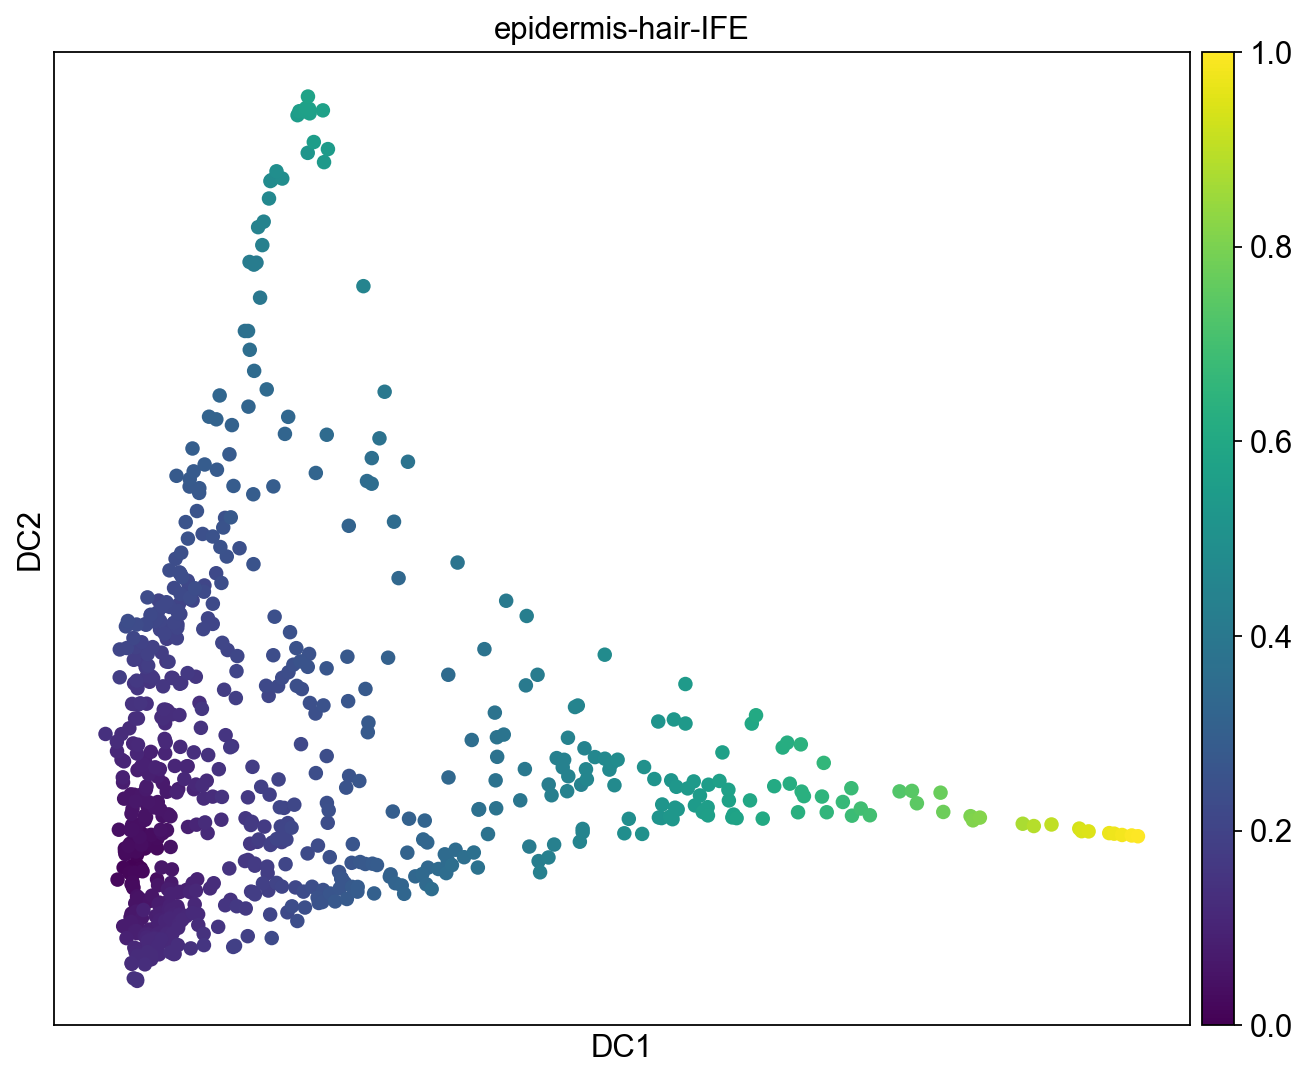

scData/mouse-cell-atlas-combination.rds.csv


/Users/lim/opt/anaconda3/envs/SCdiff/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  if is_string_dtype(df[key]) and not is_categorical(df[key])


<Figure size 640x640 with 0 Axes>

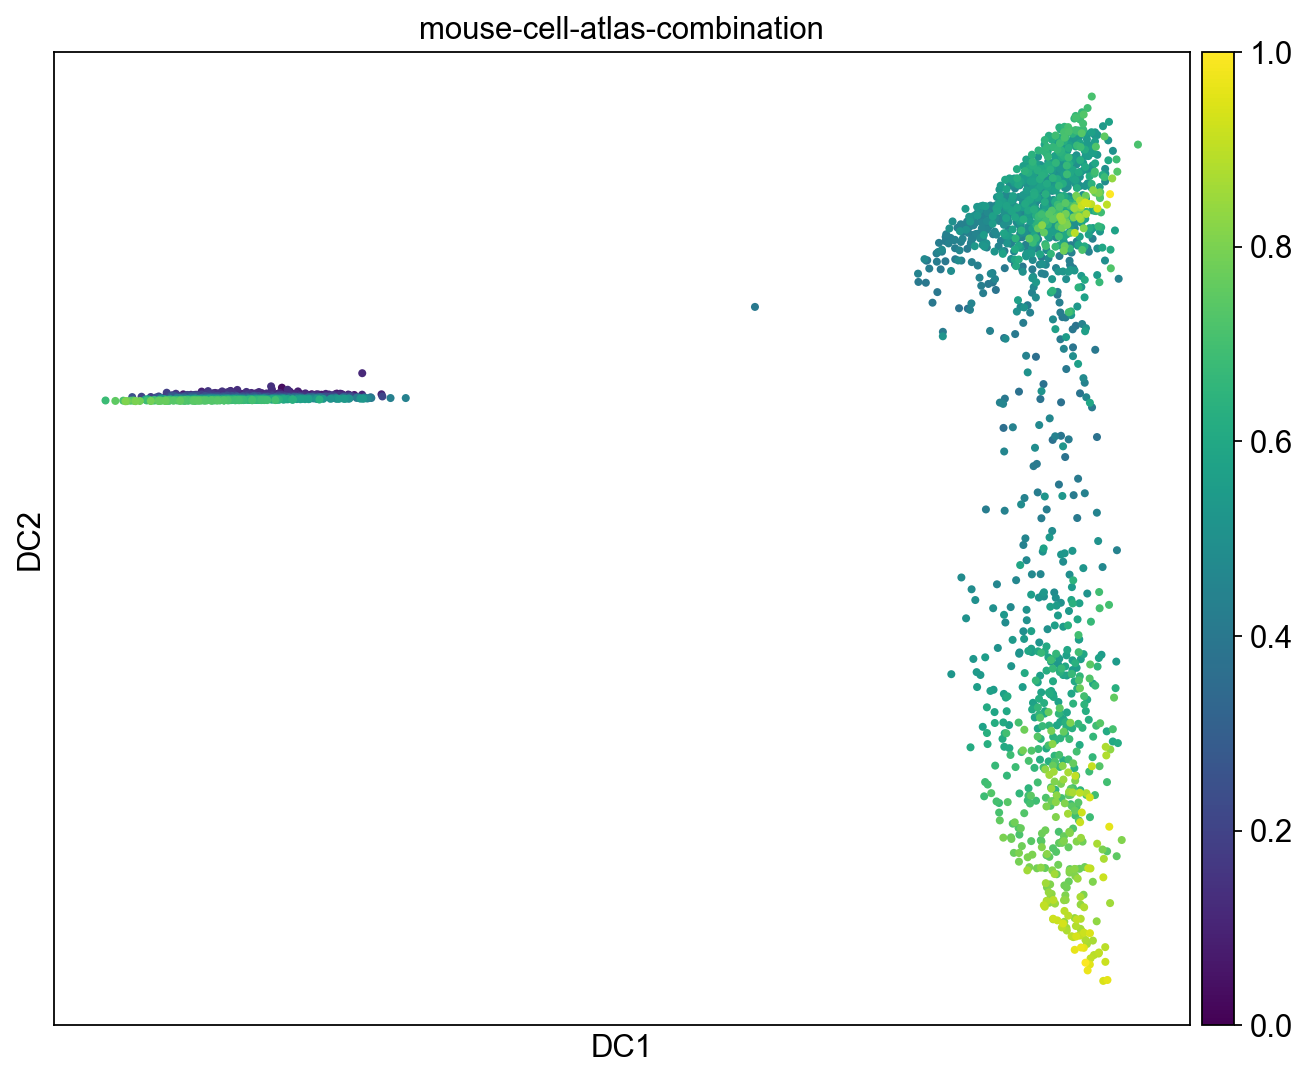

scData/planaria-parenchyme-differentiation.rds.csv


/Users/lim/opt/anaconda3/envs/SCdiff/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  if is_string_dtype(df[key]) and not is_categorical(df[key])


<Figure size 640x640 with 0 Axes>

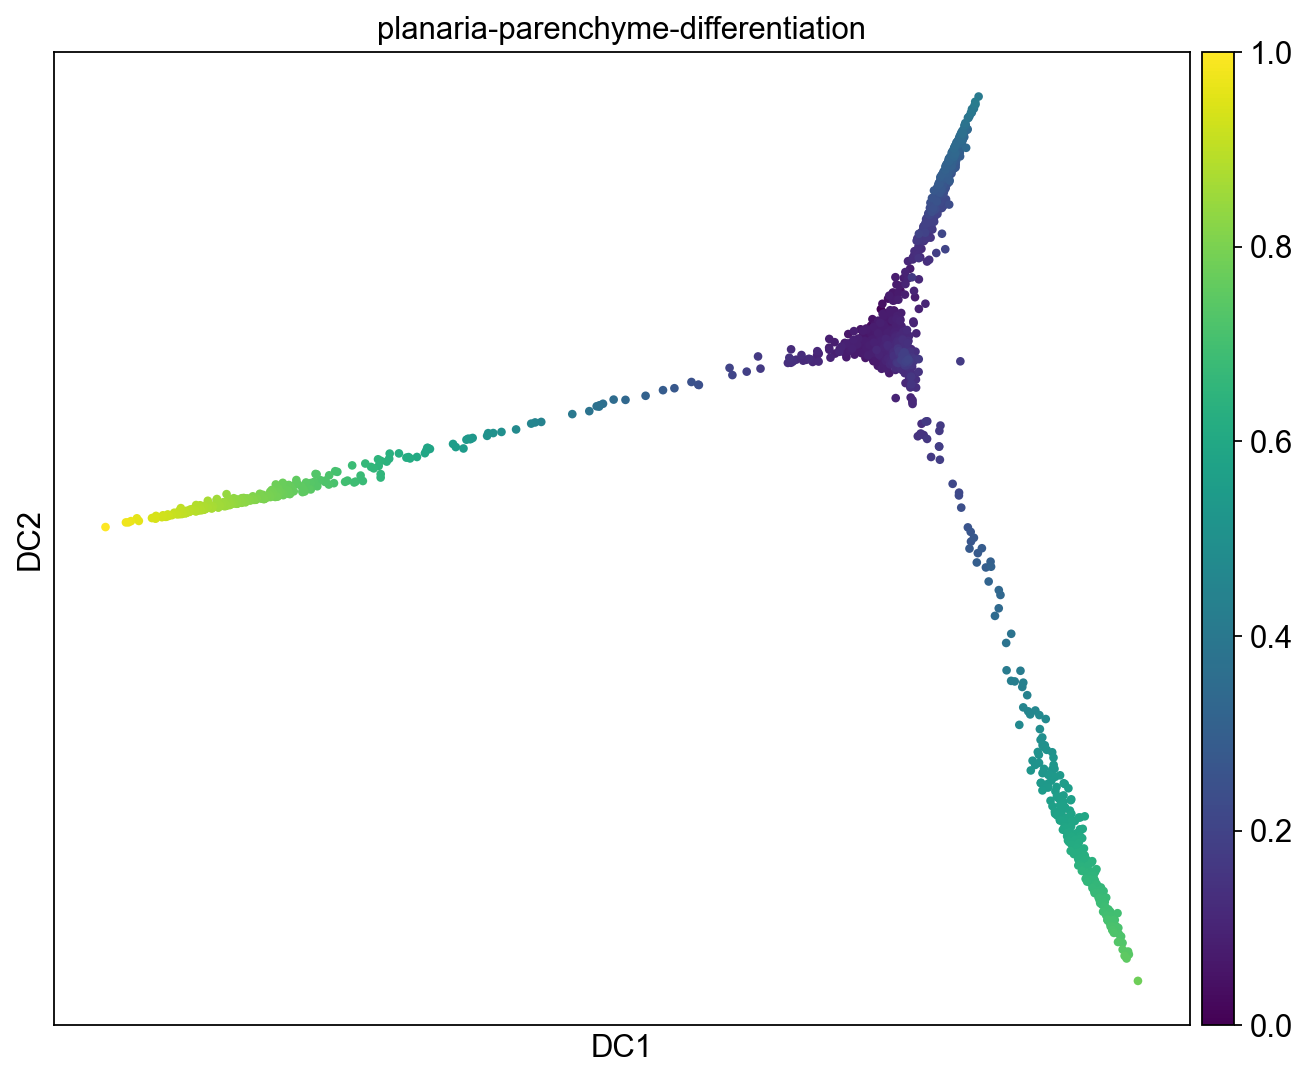

In [19]:
ct = 0 
for file in files:
    print(file)
    df = pd.read_csv(file, index_col=0)
    data = np.array(df)
    data = AnnData(data)
    data.uns['iroot'] = 0 
    plt.figure(figsize=(8,8))
    scanpy.set_figure_params(dpi=80, dpi_save=150, figsize=(10,8))
    scanpy.tl.pca(data, svd_solver='arpack')
    scanpy.pp.neighbors(data)
    scanpy.tl.diffmap(data)
    scanpy.tl.dpt(data)
    scanpy.pl.diffmap(data,color=['dpt_pseudotime'],title=simple_names[ct])
    ct+=1

In [20]:
def real_data_vis(filedir):
    df = pd.read_csv(filedir, index_col=0)
    pca = PCA(n_components=20)
    embedding_pca = pca.fit_transform(df)
    Umap = umap.UMAP()
    embedding_umap = Umap.fit_transform(embedding_pca)
    fig = plt.figure(figsize=(5,5))
    plt.scatter(embedding_umap[:,0],embedding_umap[:,1],s=5, alpha=0.8)
    plt.title('UMAP')
    plt.show()

scData/epiblast-monkey.rds.csv


/var/folders/4r/402bj5n961zdm3nb2dzxgnw80000gn/T/ipykernel_57693/4245859743.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


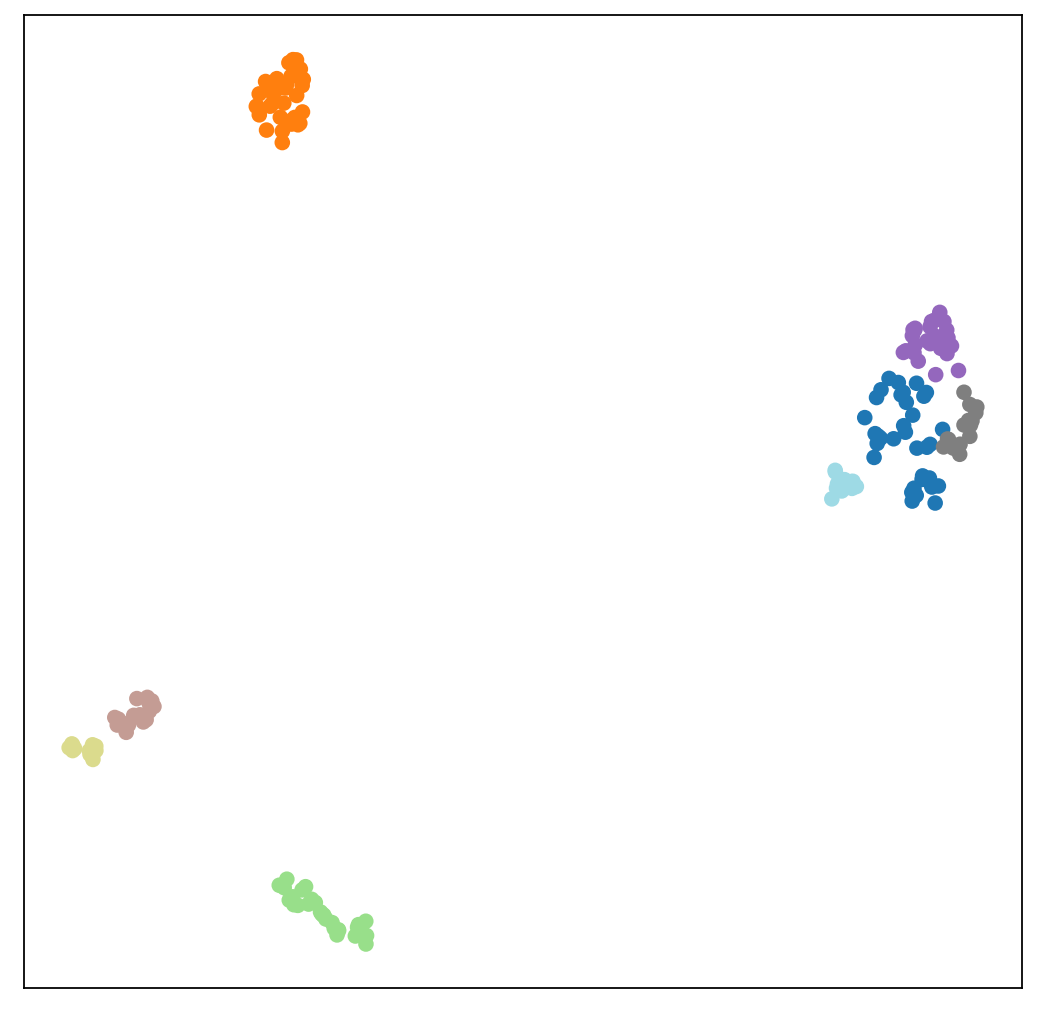

scData/planaria-combination.rds.csv


/var/folders/4r/402bj5n961zdm3nb2dzxgnw80000gn/T/ipykernel_57693/4245859743.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


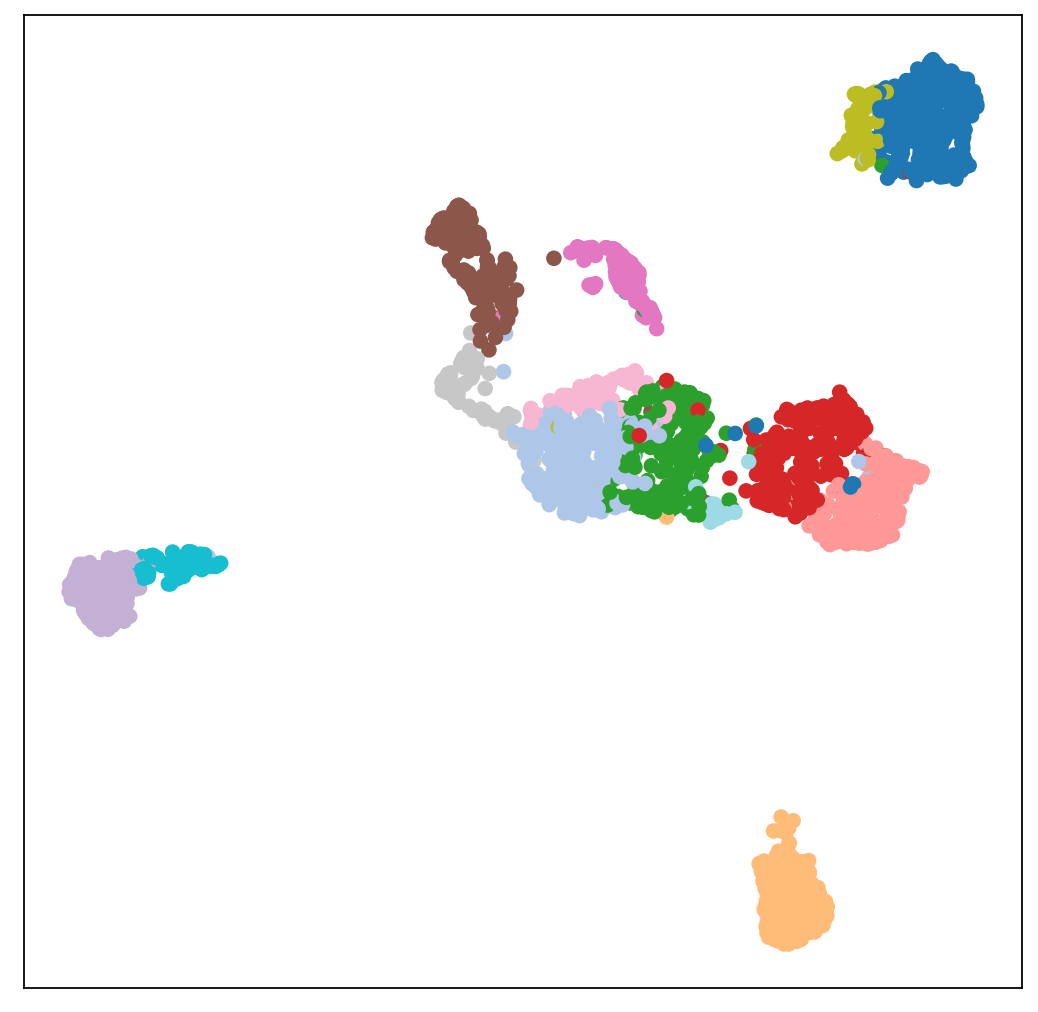

scData/bone-marrow-mesenchyme-erythrocyte.rds.csv


/var/folders/4r/402bj5n961zdm3nb2dzxgnw80000gn/T/ipykernel_57693/4245859743.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


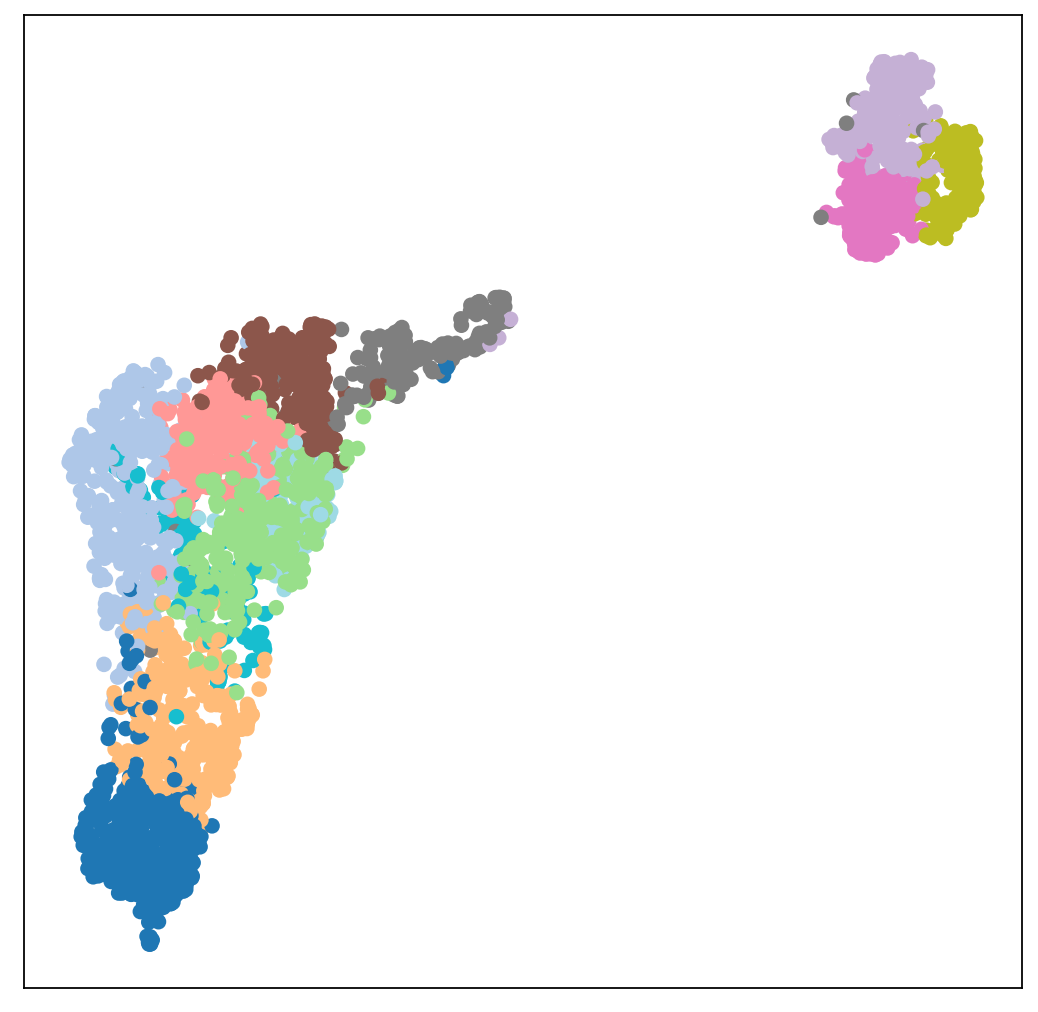

scData/NKT-differentiation.rds.csv


/var/folders/4r/402bj5n961zdm3nb2dzxgnw80000gn/T/ipykernel_57693/4245859743.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


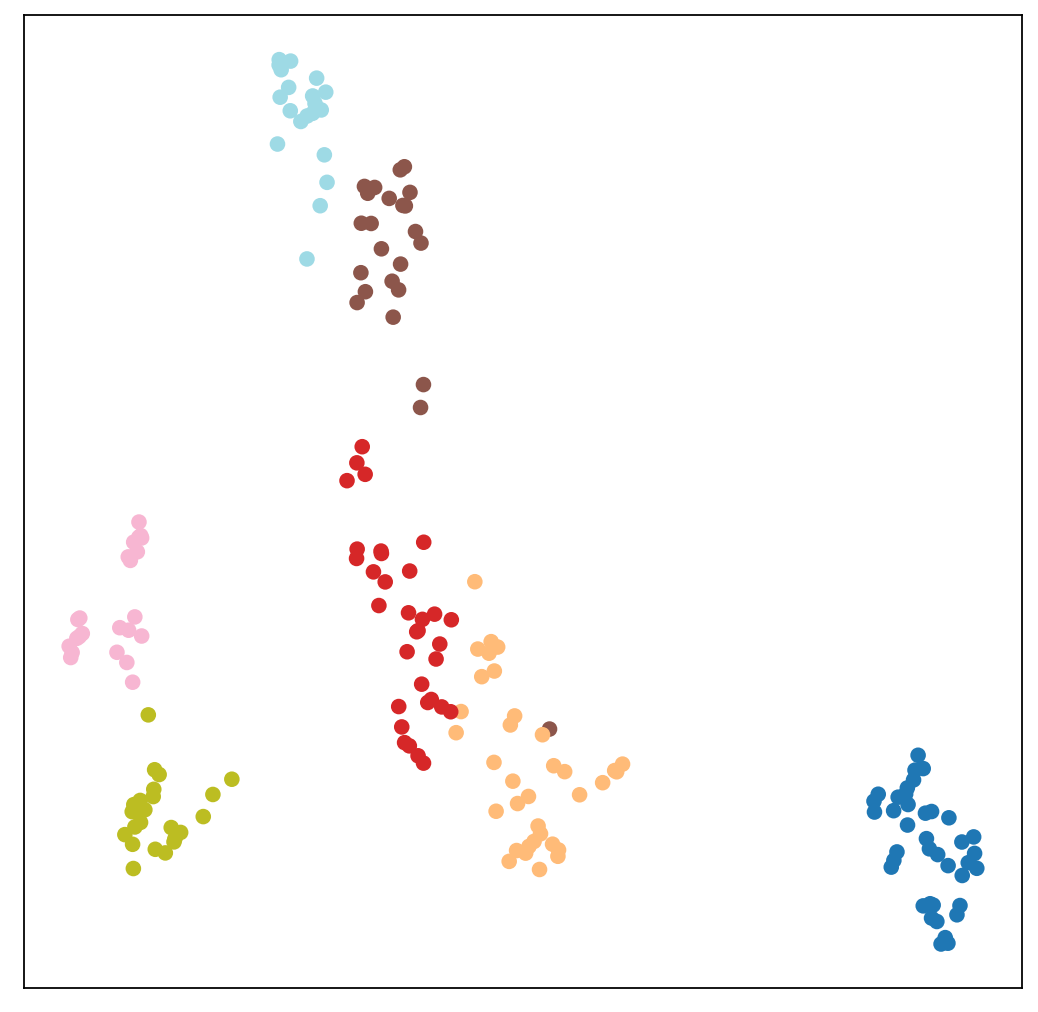

scData/dentate-gyrus-neurogenesis.rds.csv


/var/folders/4r/402bj5n961zdm3nb2dzxgnw80000gn/T/ipykernel_57693/4245859743.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


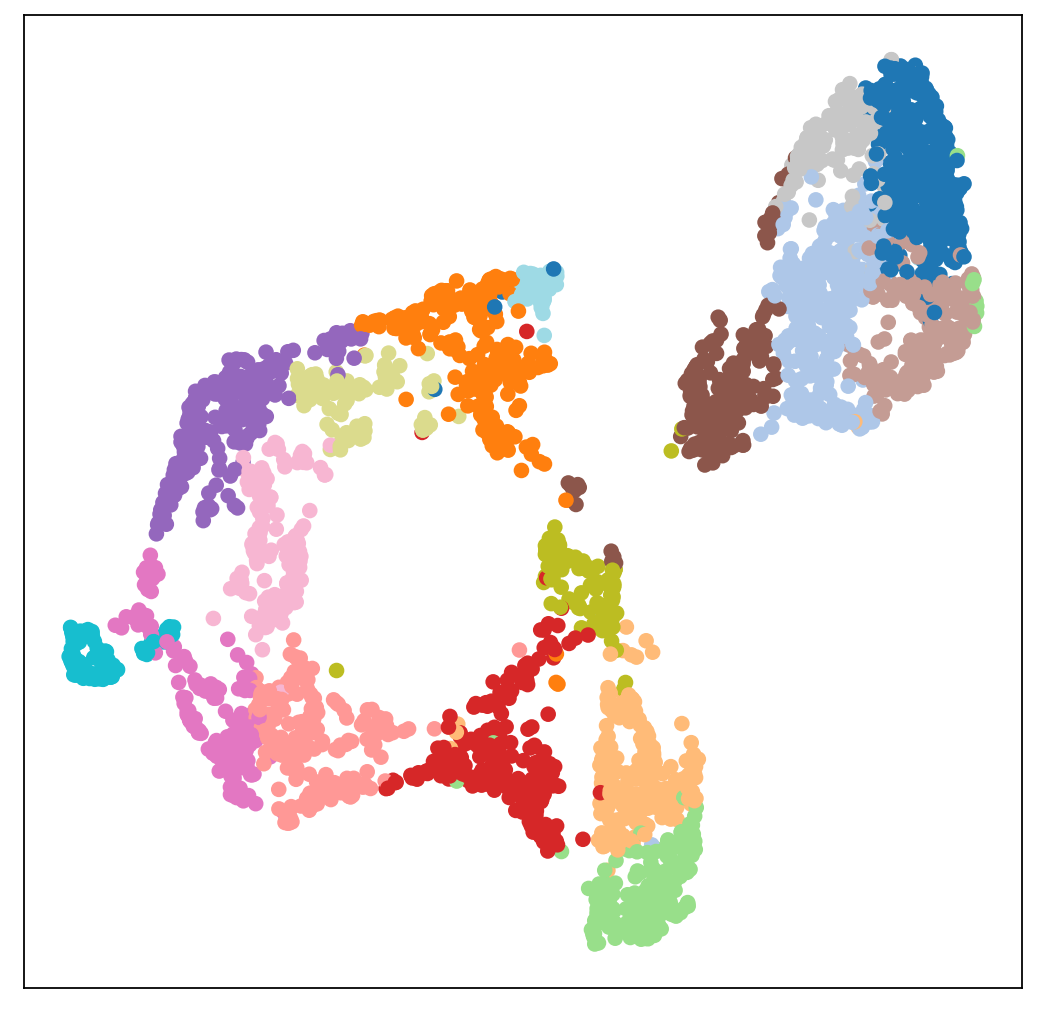

scData/epidermis-hair-IFE.rds.csv


/var/folders/4r/402bj5n961zdm3nb2dzxgnw80000gn/T/ipykernel_57693/4245859743.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


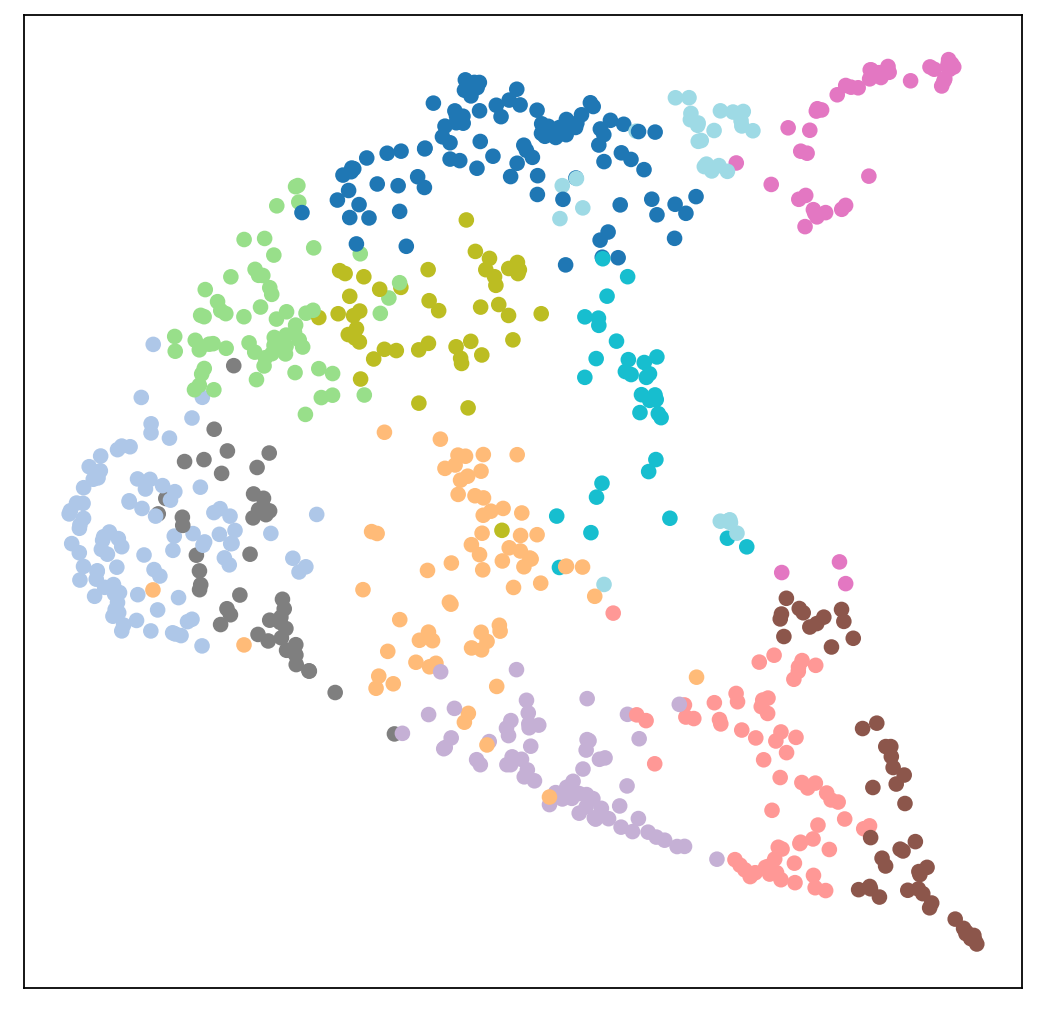

scData/mouse-cell-atlas-combination.rds.csv


/var/folders/4r/402bj5n961zdm3nb2dzxgnw80000gn/T/ipykernel_57693/4245859743.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


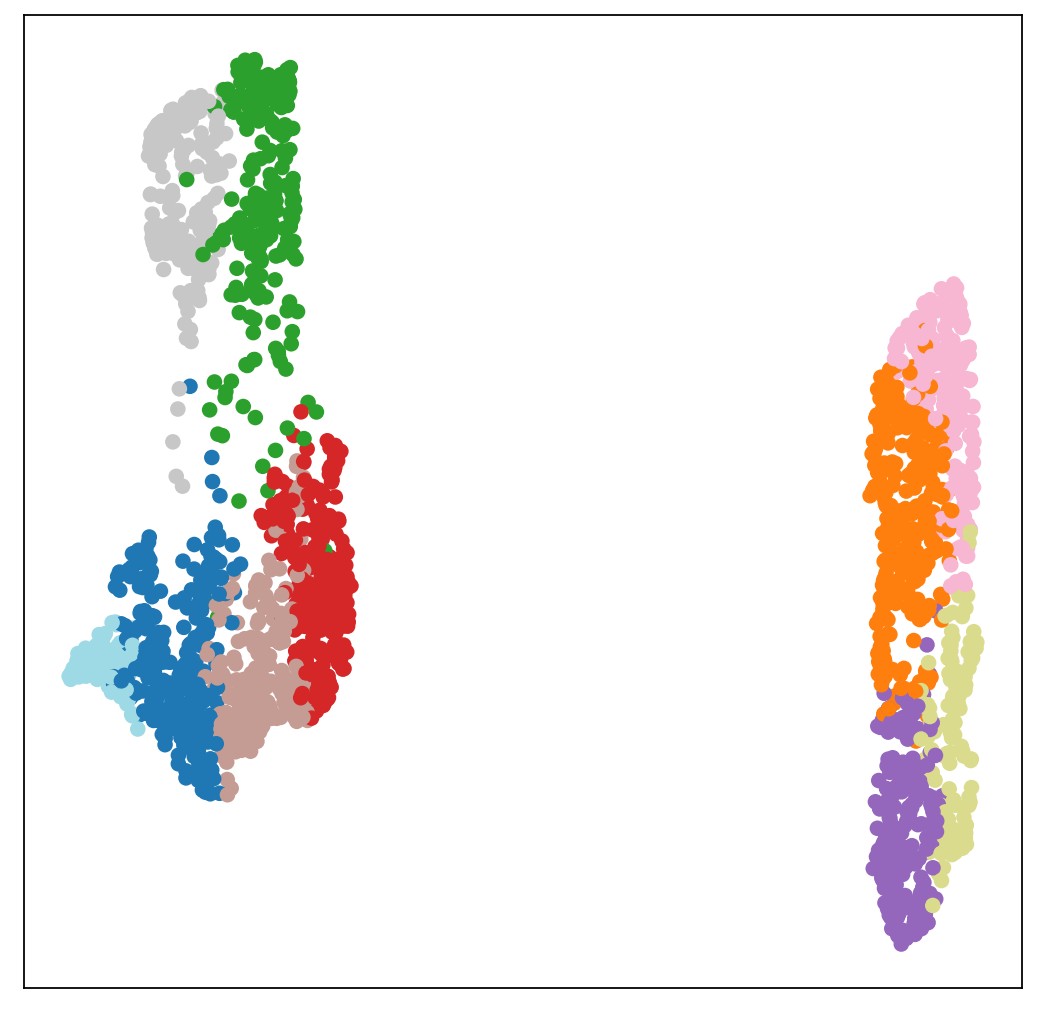

scData/planaria-parenchyme-differentiation.rds.csv


/var/folders/4r/402bj5n961zdm3nb2dzxgnw80000gn/T/ipykernel_57693/4245859743.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


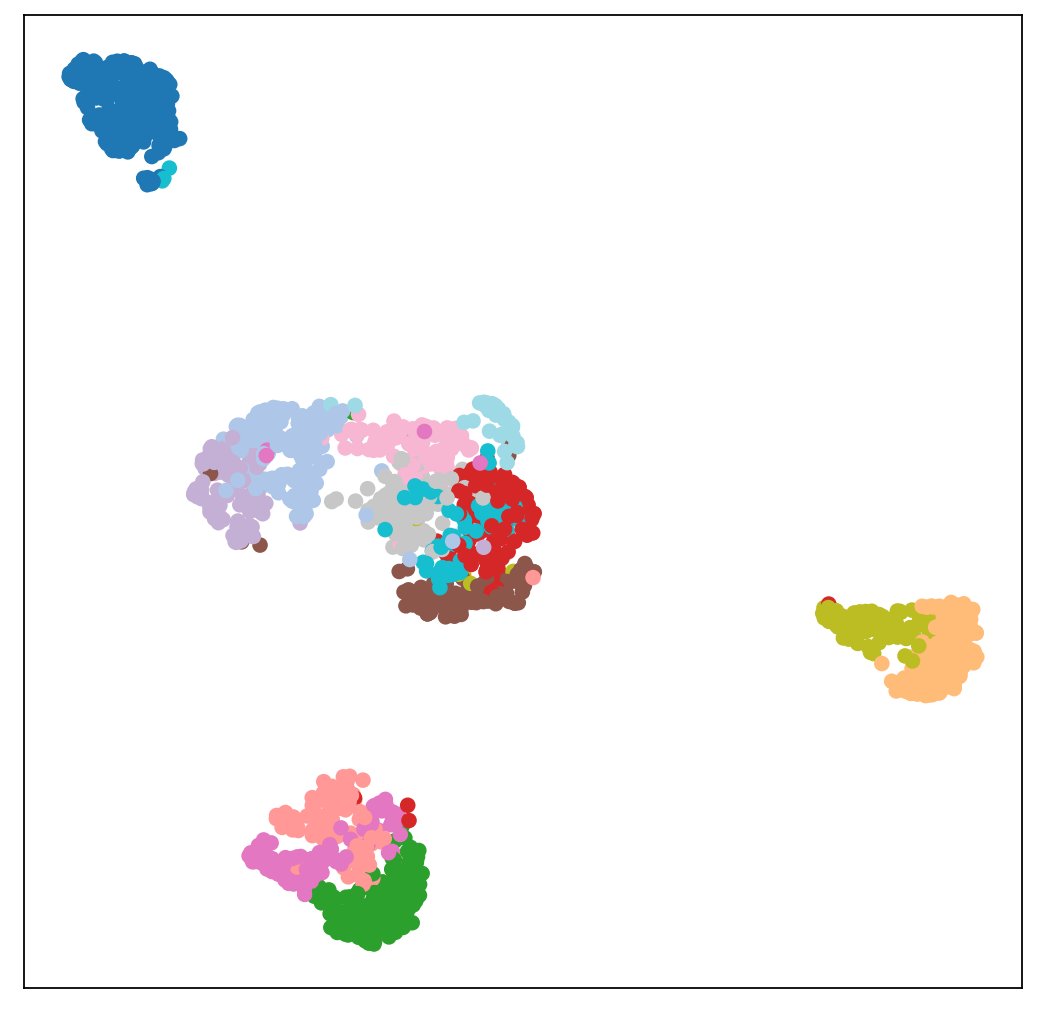

In [21]:
ct = 0
for file in files:
    print(file)
    df = pd.read_csv(file, index_col=0)
    pca = PCA(n_components=20)
    embedding_pca = pca.fit_transform(df)
    A = kneighbors_graph(embedding_pca, 10, mode='connectivity', include_self=True)
    louvain = Louvain()
    labels = louvain.fit_transform(A)
    Umap = umap.UMAP()
    embedding_umap = Umap.fit_transform(embedding_pca)
    fig = plt.figure(figsize=(8,8))
    plt.scatter(embedding_umap[:,0],embedding_umap[:,1],c=labels, alpha=1, cmap='tab20')
    #plt.title(simple_names[ct])
    plt.xticks([])
    plt.yticks([])
    plt.grid(b=None)
    plt.show()
    ct += 1